In [1]:
# import ploting tools
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import h5py

# import the MUQ libraries
import muq.Utilities as mu
import muq.Modeling as mm
import muq.Approximation as ma 
import muq.SamplingAlgorithms as ms


## Define Sampling Problems
To leverage Multilevel MCMC (MLMCMC), we need to define a hierarchy of sampling problems.  Each level will sample a different target density.   For illustration in this example, we simply use different Gaussian distributions at each level.  In practice however, it is advantageous to define coarse problems that are computationally less expensive.

In [2]:
def ConstructDensities():
    """ Returns a list of ModPieces that will evaluate the target density for each level in the chain.
        The densities are sorted from coarse-to-fine, so the last component of the list corresponds to the 
        true target density.
    """
    
    numLevels = 4
    logDensities = [None]*numLevels
    
    tgtMu = np.array([1.0, 2.0])
    tgtCov = np.array([[0.7,0.2],
                       [0.2, 1.0]])
    
    # Define the problem at the coarsest level
    levelMu  = 0.8*tgtMu
    levelCov = 2.0*tgtCov;
    logDensities[0] = mm.Gaussian(levelMu, levelCov).AsDensity()

    # Define the second coarsest level
    levelMu  = 0.9*tgtMu;
    levelCov = 1.5*tgtCov;
    logDensities[1] = mm.Gaussian(levelMu, levelCov).AsDensity()

    # Define the second finest level
    levelMu = 0.99*tgtMu;
    levelCov = 1.1*tgtCov;
    logDensities[2] = mm.Gaussian(levelMu, levelCov).AsDensity()

    # Define the finest level.  This should be the target distribution. 
    logDensities[3] = mm.Gaussian(tgtMu, tgtCov).AsDensity()
    
    return logDensities
            

In [3]:
logDensities = ConstructDensities()

#### Set Options for Sampler

In [4]:
# MLMCMC
numFineSamples = 1000
options = {
    'NumSamples_0' : numFineSamples*8, # Number of samples to take on coarsest chain
    'NumSamples_1' : numFineSamples*4,
    'NumSamples_2' : numFineSamples*2,
    'NumSamples_3' : numFineSamples,   # Number of samples to take on finest chain
    'MLMCMC.Subsampling_0' : 5,
    'MLMCMC.Subsampling_1' : 5,
    'MLMCMC.Subsampling_2' : 5,
    'MLMCMC.Subsampling_3' : 5,
    'Proposal.Method' : 'AMProposal',
    'Proposal.InitialVariance' : 0.1,
    'Proposal.AdaptSteps' : 100, # How often should the proposal covariance be adapted
    'Proposal.AdaptStart' : 500  # How many steps should be taken before adaptation begins
}

startPt = np.array([1,2]) + np.random.randn(2)
mcmc = ms.MIMCMC(options, startPt, logDensities)

samps = mcmc.Run()


### 4. Analyze the results


In [5]:
sampMean = samps.Mean()
print(f"Sample Mean = {sampMean.transpose()}")

Sample Mean = [0.86491384 1.96150118]


In [6]:
sampVar = samps.Variance()
print(f"Sample Variance = {sampVar.transpose()}")

Sample Variance = [0.92292884 0.95406204]


In [7]:
sampCov = samps.Covariance()
print(f"Sample Covariance = {sampCov}")

Sample Covariance = [[0.92292884 0.31691756]
 [0.31691756 0.95406204]]


In [8]:
sampMom3 = samps.CentralMoment(3)
print(f"Sample Third Moment = {sampMom3}")

Sample Third Moment = [-0.46638685 -0.25568585]


#### Statistical Accuracy
  

In [9]:
batchESS = samps.ESS(method="Batch")
batchMCSE = samps.StandardError(method="Batch")

spectralESS = samps.ESS(method="Wolff")
spectralMCSE = samps.StandardError(method="Wolff")

print('ESS:')
print('  Batch:    ', batchESS)
print('  Spectral: ', spectralESS)

print('MCSE:')
print('  Batch:    ', batchMCSE)
print('  Spectral: ', spectralMCSE)

ESS:
  Batch:     [91.25123083 71.16522613]
  Spectral:  [87.88205252 67.87835841]
MCSE:
  Batch:     [0.10056914 0.11578556]
  Spectral:  [0.1024788  0.11855576]


### 5. Compute convergence diagnostics
To quantitatively assess whether the chain has converged, we need to run multiple
chains and then compare the results.  Below we run 3 more independent chains (for a total of 4)
and then analyze convergence using the commonly employed $\hat{R}$ diagnostic.  A value of $\hat{R}$ close to $1$ (e.g., $<1.01$) implies that the chains have converged.  More discussion on this point, as well as a description of the split-rank approach used in MUQ to estimat $\hat{R}$, can be found in [Rank-normalization, folding, and localization: An improved R for assessing convergence of MCMC](https://arxiv.org/pdf/1903.08008.pdf).

Notice that a new MCMC sampler is defined each time with a randomly selected starting point.  If we simply called `mcmc.Run()`
multiple times, the sampler would always pick up where it left off.  For the estimation of $\hat{R}$, it is also important that 
the initials states of these chains be drawn from a distribution that is more "diffuse" than the target distribution.

In [10]:
numChains = 4

chains = [samps]

for i in range(numChains):
    print("Running chain {}...".format(i), flush=True)
    
    startPt = np.array([1,2]) + np.random.randn(2)
    mcmc = ms.MIMCMC(options, startPt, logDensities)
    
    chains.append( mcmc.Run() )

Running chain 0...
Running chain 1...
Running chain 2...
Running chain 3...


In [11]:
rhat = ms.Diagnostics.Rhat(chains)
print("Rhat = ", rhat)

Rhat =  [1.00273054 1.00152371]


### 6. Plot the Samples

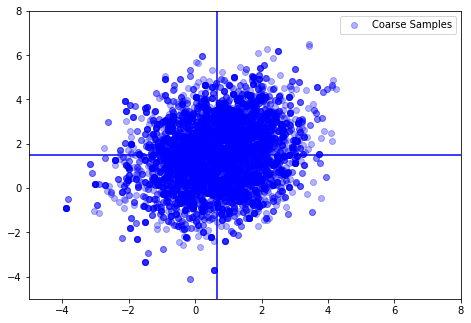

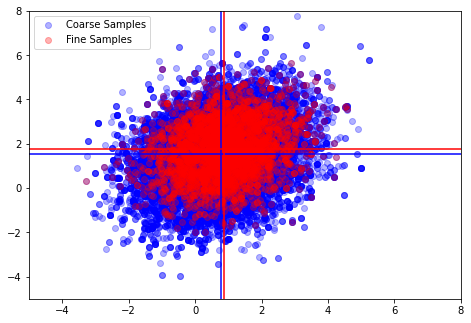

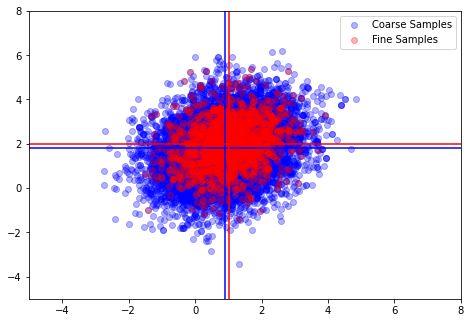

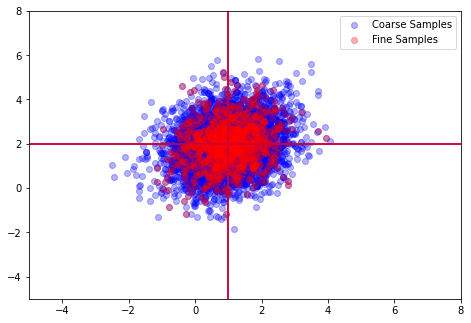

In [12]:
# Let's dive into the MIMCMC data structures to do some post processing


# Iterate over all multiindices we have
mlindices = mcmc.GetIndices()
for i in range(0,mlindices.Size()):
    
    # Get the MIMCMCBox representing the telescoping sum component associated with this index
    box = mcmc.GetMIMCMCBox(mlindices.at(i))
    boxIndices = box.GetBoxIndices()
    
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    plt.xlim(-5, 8)
    plt.ylim(-5, 8)

    # Plot all samples of every MCMC chain of this box
    for i in range(0,boxIndices.Size()):
        boxIndex = boxIndices.at(i)
        
        samplesMat = box.GetChain(boxIndex).GetSamples().AsMatrix()

        if boxIndex.GetValue(0) == 0:
            ax.scatter(samplesMat[0,:], samplesMat[1,:], color='b', alpha=0.3, label="Coarse Samples")
        else:
            ax.scatter(samplesMat[0,:], samplesMat[1,:], color='r', alpha=0.3, label="Fine Samples")
        
    ax.legend()

    # Plot all mean values of every MCMC chain of this box
    for i in range(0,boxIndices.Size()):
        boxIndex = boxIndices.at(i)
        boxChain = box.GetChain(boxIndex)
        mean = boxChain.GetSamples().Mean()
        
        plt.axvline(x=mean[0], color='b' if boxIndex.GetValue(0) == 0 else 'r');
        plt.axhline(y=mean[1], color='b' if boxIndex.GetValue(0) == 0 else 'r');
